# Week 3 - Feature Based Segmentation

In [92]:
import os
import sys
import scipy
import skimage.io
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

sys.path.append(os.path.join(os.path.abspath(''), '..', '..'))
import toolbox
import imp
imp.reload(toolbox)

<module 'toolbox' from '/Users/williammarstrand/privat/DTU/Kandidat/1. Semester/Advanced Image Analysis/02506-advanced-image-analysis/exercises/week3/../../toolbox/__init__.py'>

### (A) Compute Features

1) Training image

In [3]:
train_img = skimage.io.imread(os.path.join('data', '2labels', 'training.png'))

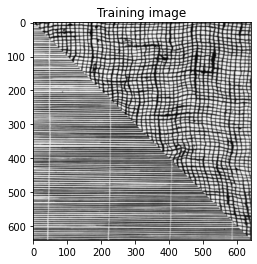

In [4]:
plt.title('Training image')
plt.imshow(train_img, cmap='gray')
plt.show()

2) Computing feature image

In [63]:
sigmas = [1,2,3]
train_fimg = toolbox.features.get_gauss_feat_multi(train_img, sigmas)
train_fimg.shape

(409600, 3, 15)

3) Displaying selected layers of feature image

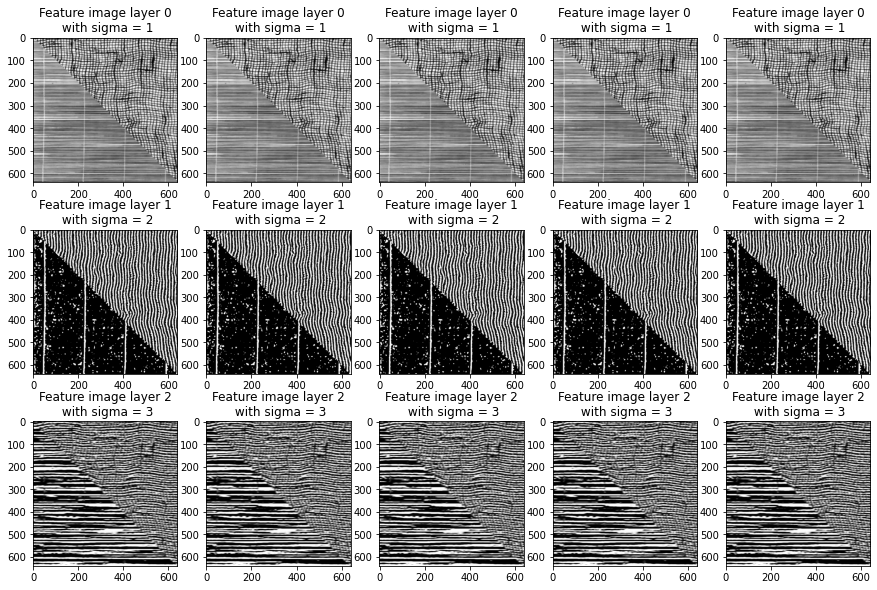

In [64]:
layers = [0, 1, 5, 10, 15]

fig, ax = plt.subplots(3, 5, figsize=(15,10))

for i in range(train_fimg.shape[1]):
    for j,l in enumerate(layers):
        ax[i, j].set_title(f'Feature image layer {i}\n with sigma = {sigmas[i]}')
        ax[i, j].imshow(train_fimg[:,i,i].reshape(train_img.shape), cmap='gray')

plt.show()

4) Transform feature vector from (r\*c, n , 15) to (r\*c,15n)
    - Each row will be a feature vector of size 15n

In [65]:
transformed_train_fimg = train_fimg.reshape((train_fimg.shape[0], train_fimg.shape[1]*train_fimg.shape[2]))
transformed_train_fimg.shape

(409600, 45)

### (B)  Prepare labels for clustering

Loading training label image

In [67]:
train_label_img = skimage.io.imread(os.path.join('data', '2labels', 'training_labels.png'))
train_label_img.shape

(640, 640)

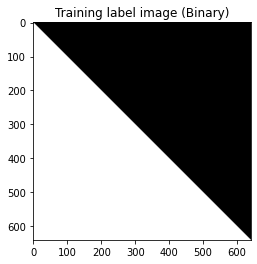

In [68]:
plt.title('Training label image (Binary)')
plt.imshow(train_label_img, cmap='gray')
plt.show()

Transforming training_label image to label probability image

In [69]:
labels = train_label_img.ravel()
unique_labels = np.asarray(list(set(train_label_img.flatten().tolist())))
unique_labels

array([  0, 255])

In [70]:
prob_img = np.asarray(list(map(lambda p: p == unique_labels, train_label_img.flatten()))).reshape(
                                (train_label_img.shape[0], train_label_img.shape[1], unique_labels.shape[0]))

### (C) Build dictionary

In [71]:
nr_keep = 15000 # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(transformed_train_fimg.shape[0]))[:nr_keep]

In [72]:
feature_subset = transformed_train_fimg[keep_indices, :]
labels_subset = labels[keep_indices]

In [73]:
clusters = 1000
kmeans = MiniBatchKMeans(n_clusters=clusters, batch_size=2*clusters)
kmeans.fit(feature_subset)
assignment = kmeans.labels_

In [84]:
label_cluster_prob = np.zeros((len(unique_labels), clusters))

for c in tqdm(range(clusters)):
    c_labels = labels_subset[assignment == c]

    for i, l in enumerate(unique_labels):
        label_cluster_prob[i, c] = np.sum(c_labels == l)/len(c_labels) 

100%|██████████| 1000/1000 [00:00<00:00, 23686.06it/s]


#### Histogram of Cluster Probabilities

/var/folders/bb/6zx8vn690fd_kml8spjg6j8h0000gn/T/ipykernel_47599/4202940177.py:7: RuntimeWarning: invalid value encountered in true_divide
  cluster_probabilities = hist/(sum_hist.reshape(-1,1))


Text(0.5, 1.0, 'cluster probabilities')

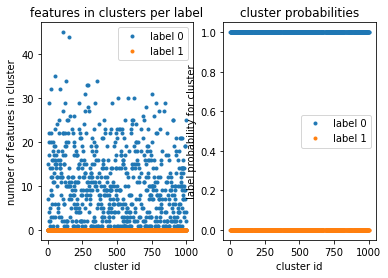

In [90]:
nr_labels = len(unique_labels)
edges = np.arange(clusters+1)-0.5 # histogram edges halfway between integers
hist = np.zeros((clusters,nr_labels))
for l in range(nr_labels):
    hist[:,l] = np.histogram(assignment[labels_subset==l],bins=edges)[0]
sum_hist = np.sum(hist,axis=1)
cluster_probabilities = hist/(sum_hist.reshape(-1,1))

fig, ax = plt.subplots(1,2)
legend_label = [f'label {x}' for x in range(nr_labels)]

ax[0].plot(hist,'.')
ax[0].set_xlabel('cluster id')
ax[0].set_ylabel('number of features in cluster')
ax[0].legend(legend_label)
ax[0].set_title('features in clusters per label')
ax[1].plot(cluster_probabilities,'.')
ax[1].set_xlabel('cluster id')
ax[1].set_ylabel('label probability for cluster')
ax[1].legend(legend_label)
ax[1].set_title('cluster probabilities')


### (D) Assign dictionary to test image

/var/folders/bb/6zx8vn690fd_kml8spjg6j8h0000gn/T/ipykernel_47599/4041788989.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testing_image = testing_image.astype(np.float)


Text(0.5, 1.0, 'probabilities for testing image as RGB')

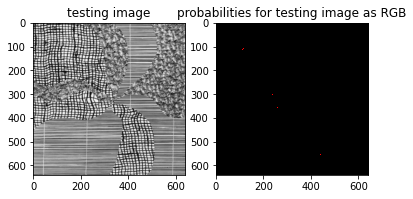

In [91]:
testing_image = skimage.io.imread(os.path.join('data', '3labels', 'testing_image.png'))
testing_image = testing_image.astype(np.float)

features_testing = toolbox.features.get_gauss_feat_multi(testing_image, sigmas)
features_testing = features_testing.reshape((features_testing.shape[0], features_testing.shape[1]*features_testing.shape[2]))

assignment_testing = kmeans.predict(features_testing)

probability_image = np.zeros((assignment_testing.size, nr_labels))
for l in range(nr_labels):
    probability_image[:,l] = cluster_probabilities[assignment_testing, l]
probability_image = probability_image.reshape(testing_image.shape + (nr_labels,))

P_rgb = np.zeros(probability_image.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb[:,:,:k] = probability_image[:,:,:k]

fig, ax = plt.subplots(1,2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')



### (E) Compute probability image and segmentation

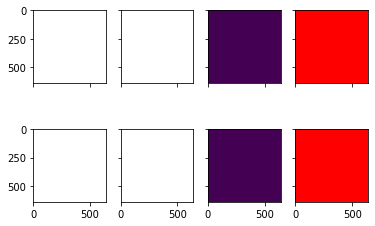

In [93]:
sigma = 3 # Gaussian smoothing parameter

seg_im_max = np.argmax(P_rgb,axis = 2)
c = np.eye(P_rgb.shape[2])
P_rgb_max = c[seg_im_max]

probability_smooth = np.zeros(probability_image.shape)
for i in range(0,probability_image.shape[2]):
    probability_smooth[:,:,i] = scipy.ndimage.gaussian_filter(probability_image[:,:,i],sigma,order=0)
seg_im_smooth = np.argmax(probability_smooth,axis=2)

probability_smooth_max = c[seg_im_smooth]

P_rgb_smooth = np.zeros(probability_smooth_max.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb_smooth[:,:,:k] = probability_smooth[:,:,:k]
P_rgb_smooth_max = np.zeros(probability_smooth_max.shape[0:2]+(3,))
P_rgb_smooth_max[:,:,:k] = probability_smooth_max[:,:,:k]

# Display result
fig,ax = plt.subplots(2,4,sharex=True,sharey=True)
ax[0][0].imshow(P_rgb[:,:,0])
ax[0][1].imshow(P_rgb[:,:,1])
ax[0][2].imshow(P_rgb[:,:,2])
ax[0][3].imshow(P_rgb_max)
ax[1][0].imshow(P_rgb_smooth[:,:,0])
ax[1][1].imshow(P_rgb_smooth[:,:,1])
ax[1][2].imshow(P_rgb_smooth[:,:,2])
ax[1][3].imshow(P_rgb_smooth_max)
